# Advanced usage of Quantum Random Access Optimization

The [first tutorial](https://github.com/qiskit-community/prototype-qrao/blob/main/docs/tutorials/01_getting_started.ipynb) demonstrated basic usage of Quantum Random Access Optimization: how to generate a `QuadraticProgram` based on the max-cut problem, encode it into a Hamiltonian, and find a candidate solution using `QuantumRandomAccessOptimizer` with semideterministic rounding.  In this second tutorial, we will explore advanced usage of QRAO. In particular, we will use a different form of rounding, called "magic rounding."  Unlike semideterministic rounding (which only involves classical post-processing), magic rounding executes on a quantum backend, which can be a simulator or actual quantum hardware.

In the first part of this tutorial, you will learn how to solve a problem using the same technique as the first tutorial, but with magic rounding in place of semideterministic rounding.  In the second part, you will learn how to explicitly invoke the two primary steps behind solving the relaxed problem: running a minimum eigensolver to find an approximate ground state solution of the encoded (relaxed) Hamiltonian and performing rounding to map these ground state results back to a solution of the original problem.

More conceptual information about the different rounding schemes is available in the [explanatory material](https://github.com/qiskit-community/prototype-qrao/blob/main/docs/background/quantum_relaxations.ipynb).

First, we perform similar imports as in the first tutorial, with the addition of `MagicRounding`.

In [1]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms.minimum_eigen_solvers import VQE
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import SPSA

from qrao import (
    QuantumRandomAccessOptimizer,
    QuantumRandomAccessEncoding,
    SemideterministicRounding,
    MagicRounding,
)
from qrao.utils import get_random_maxcut_qp

## Set up the problem and encode it into a quantum Hamiltonian

Like in the previous tutorial, we begin by generating a `QuadraticProgram` from a random max-cut instance and encoding it into a relaxed Hamiltonian:

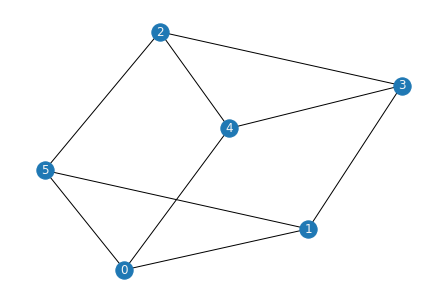

In [2]:
# Generate a random QUBO in the form of a QuadraticProgram
problem = get_random_maxcut_qp(degree=3, num_nodes=6, seed=1, draw=True)

# Create and encode the problem using the (3,1,p)-QRAC
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
encoding.encode(problem)

## Solve the problem using the `QuantumRandomAccessOptimizer` with magic rounding

Magic rounding is a quantum technique that we use to map the ground state results of our encoded Hamiltonian back to a solution of the original problem. Unlike semideterministic rounding, this technique requires a quantum backend (either hardware or a simulator). This backend is passed to `MagicRounding` via a `QuantumInstance`, which also determines the total shots count (samples) magic rounding will use. This means we need to specify a quantum instance for both the optimizer and the rounding scheme steps. In principle, we could use the same or a different quantum instance for each of these steps. 

In practice, users may be inclined to set the number of magic rounding shots to be much higher than the number of shots used by the minimum eigensolver for the relaxed problem. This is because the minimum eigensolver is estimating expectation values but the magic rounding scheme will be returning the sample corresponding to the maximum function value found. When estimating an expectation value, increasing the number of shots will cause the estimate to converge to the true value, but when trying to find the largest possible function value we will often be trying to sample from the tail of a distribution of outcomes. Thus, until we observe the highest value outcome of our distribution, each additional shot increases the expected return value.

In this tutorial, we use the `"aer_simulator"` both for solving the relaxed Hamiltonian and for performing magic rounding, albeit with a different `shots` count for each step. 

In [3]:
backend = Aer.get_backend("aer_simulator")

# Create a QuantumInstance for solving the relaxed Hamiltonian using VQE
relaxed_qi = QuantumInstance(backend=backend, shots=500)

# Create a QuantumInstance for magic rounding
rounding_qi = QuantumInstance(backend=backend, shots=1000)

# Set up the variational quantum eigensolver (ansatz width is determined by the encoding)
vqe = VQE(
    ansatz=RealAmplitudes(encoding.num_qubits),
    optimizer=SPSA(maxiter=50),
    quantum_instance=relaxed_qi,
)

# Use magic rounding
rounding_scheme = MagicRounding(rounding_qi)

# Construct the optimizer
qrao = QuantumRandomAccessOptimizer(
    encoding=encoding, min_eigen_solver=vqe, rounding_scheme=rounding_scheme
)

In [4]:
# Solve the optimization problem
results = qrao.solve()
print(results)

QRAO Result
-----------
relaxed function value: 17.232
optimal function value: 14.0
optimal value: [1 0 1 1 0 0]
status: SUCCESS


Because magic rounding involves nondeterministic measurements, the method collects a number of samples given by the `shots` count provided to the `rounding_qi` above.  These samples are then consolidated, such that duplicates are combined and factored into the empirical `probability` of the `SolutionSample`. Each sample has a corresponding function value (`fval`). From these consolidated samples, we select the one with the "optimal" (highest in the case of max-cut) function value as our solution.

In [5]:
# Calculate number of consolidated samples
len(results.samples)

64

Each `SolutionSample` can be inspected individually.<br>
(_Note: "status" indicates that the optimizer executed without raising an exception and does not refer to optimality of a solution sample_)

In [6]:
# The first solution sample (which is not optimal in this case since the optimal
# function value is 14.0)
results.samples[0]

SolutionSample(x=array([1, 0, 1, 0, 0, 0]), fval=12.0, probability=0.026, status=<OptimizationResultStatus.SUCCESS: 0>)

Information about the optimal value is available directly in the `results` object:

In [7]:
print(f"The optimal function value is {results.fval} at {results.x}.")

The optimal function value is 14.0 at [1 0 1 1 0 0].


## Alternative: Solve the problem in two explicit steps

In the first part of this tutorial, we called the `qrao.solve()` method, which solves the encoded problem (ground state of the relaxed Hamiltonian) and performs rounding (to map the ground state results back to a solution of the original problem). It is also possible to explicitly break down the calculation into these two component steps. This may be useful, for example, if you would like to compare the solutions obtained across multiple rounding schemes performed on a candidate ground state.

In this section, we will learn how to perform each of these steps explicitly.

### 1. Manually solve the relaxed problem

First, call the method `qrao.solve_relaxed()` to solve the relaxed problem directly. This relaxed problem was already given to the `QuantumRandomAccessOptimizer` object at construction via the `encoding`. The `solve_relaxed` method returns two objects:
- `MinimumEigensolverResult`: result of the VQE run (explanation of entries in this dictionary is [documented in Qiskit Terra](https://qiskit.org/documentation/stubs/qiskit.algorithms.MinimumEigensolverResult.html))
- `RoundingContext`: information about the encoding and the solution of the relaxed problem in a form that is ready for consumption by the rounding schemes

In [8]:
# Solve the relaxed problem manually
relaxed_results, rounding_context = qrao.solve_relaxed()

In [9]:
# Print the MinimumEigensolverResult object, from Terra
print(relaxed_results)

{   'aux_operator_eigenvalues': [   (0.728, 0.03065994129152892),
                                    (-0.7479999999999998, 0.02968150939558162),
                                    (   -0.023999999999999952,
                                        0.04470847794322683),
                                    (0.932, 0.016209626769299778),
                                    (   -0.008000000000000007,
                                        0.04471992844359212),
                                    (   -0.023999999999999962,
                                        0.04470847794322683)],
    'cost_function_evals': 100,
    'eigenstate': {   '000': 0.2683281572999748,
                      '001': 0.07745966692414834,
                      '010': 0.5157518783291051,
                      '011': 0.363318042491699,
                      '100': 0.39749213828703583,
                      '101': 0.4919349550499537,
                      '110': 0.20976176963403032,
                      '111': 0.282

### 2. Manually round the relaxed problem results

Second, perform rounding on these relaxed problem results. We do this by calling the `round()` method on an instantiation of the desired rounding scheme and passing it the `RoundingContext`. Here, we provide an example for both rounding schemes, given the relaxed solution obtained above.

_Note: in the future, we will expose functionality to easily translate the results obtained by manually rounding back to the solution of original problem. Currently, this happens automatically when calling `QuantumRandomAccessOptimizer.solve(problem)`._

In [10]:
mr_results = MagicRounding(rounding_qi).round(rounding_context)
print(
    f"Collected {len(mr_results.samples)} samples in {mr_results.time_taken} seconds."
)

Collected 64 samples in 2.1042749881744385 seconds.


In [11]:
sdr_results = SemideterministicRounding().round(rounding_context)
print(f"Performed semideterministic rounding ({len(sdr_results.samples)} sample).")
print(f"Result: {sdr_results.samples[0]}")

Performed semideterministic rounding (1 sample).
Result: RoundingSolutionSample(x=array([0, 1, 1, 0, 1, 1]), probability=1.0)


In [12]:
import qiskit.tools.jupyter  # pylint: disable=unused-import,wrong-import-order

%qiskit_version_table
%qiskit_copyright